### Torch tuto on RNNs

Inspired from "Hands-On Machine Learning wuth Scikit-Learn, Keras and Tensorflow" (A Géron)
Translated to PyTorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
def seed_everything(seed=42):
    """
    Set seed for reproducibility.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed for reproducibility
seed_everything(42)

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 3080
Total GPU Memory: 9.8 GB


Data Generation for Time Series Forecasting

In [4]:
def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.8 * np.sin((time - o1) * (f1 * 10 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o1) * (f1 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [5]:
n_steps = 150
n_series = 10000
s = generate_time_series(n_series, n_steps+1)

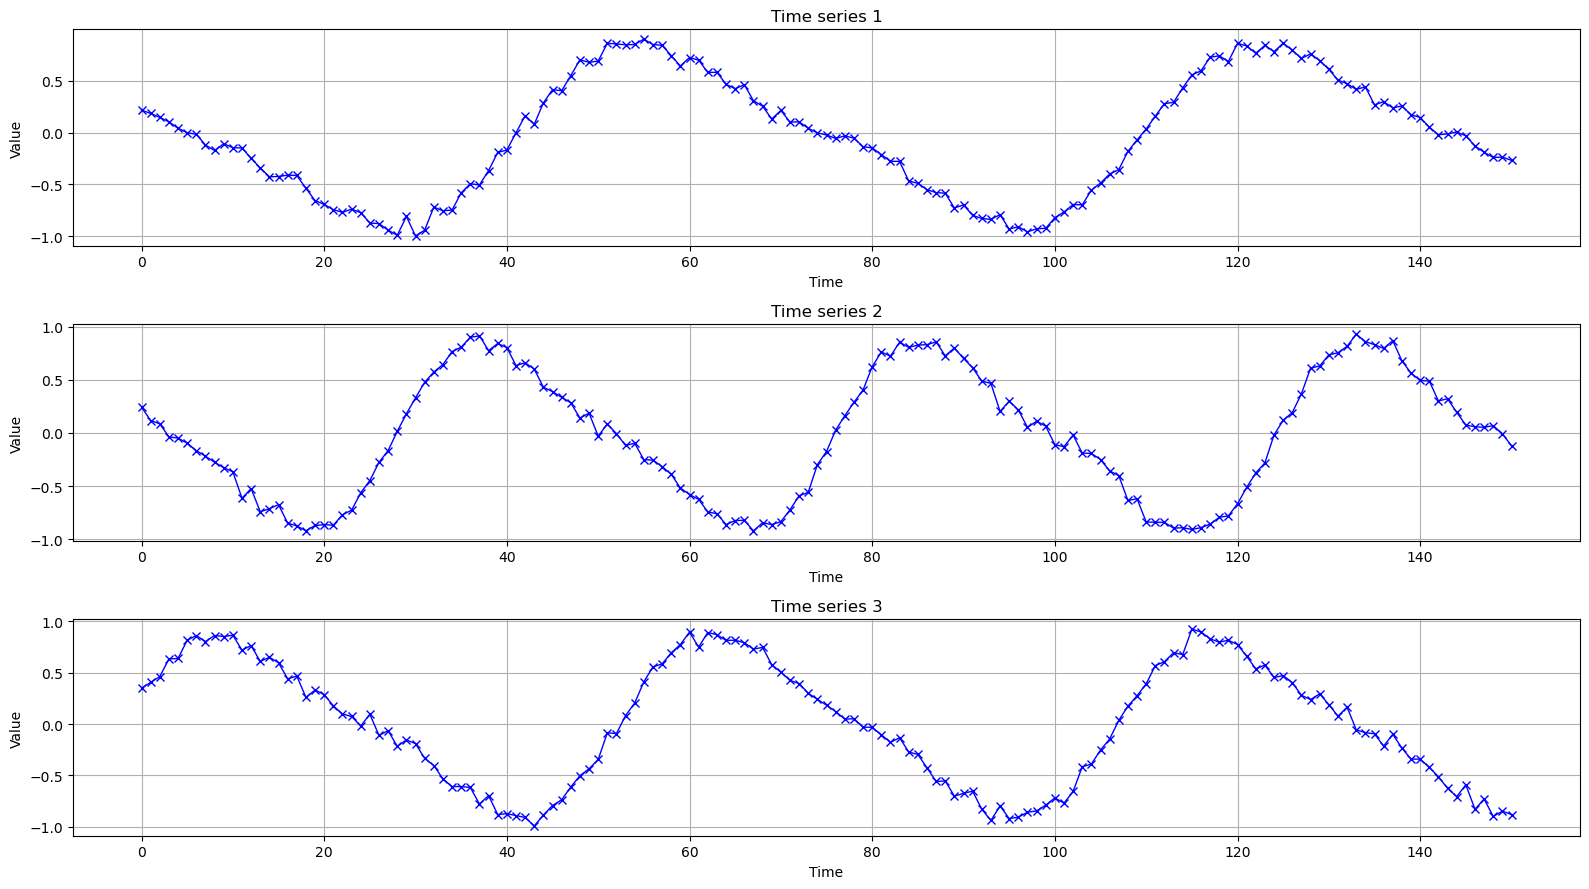

In [6]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [7]:
X_train, y_train = s[:7000,:n_steps], s[:7000,-1]
X_valid, y_valid = s[7000:9000,:n_steps], s[7000:9000,-1]
X_test, y_test = s[9000:,:n_steps], s[9000:,-1]

In [8]:
# form datasets, dataloaders, etc

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
valid_dataset = TimeSeriesDataset(X_valid, y_valid)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Baseline metrics

In [9]:
# Predicted value is the last value of the time series

y_pred = X_valid[:,-1]
print(f"{np.mean(np.sqrt((y_valid - y_pred) ** 2)):.4f} RMSE")

0.0778 RMSE


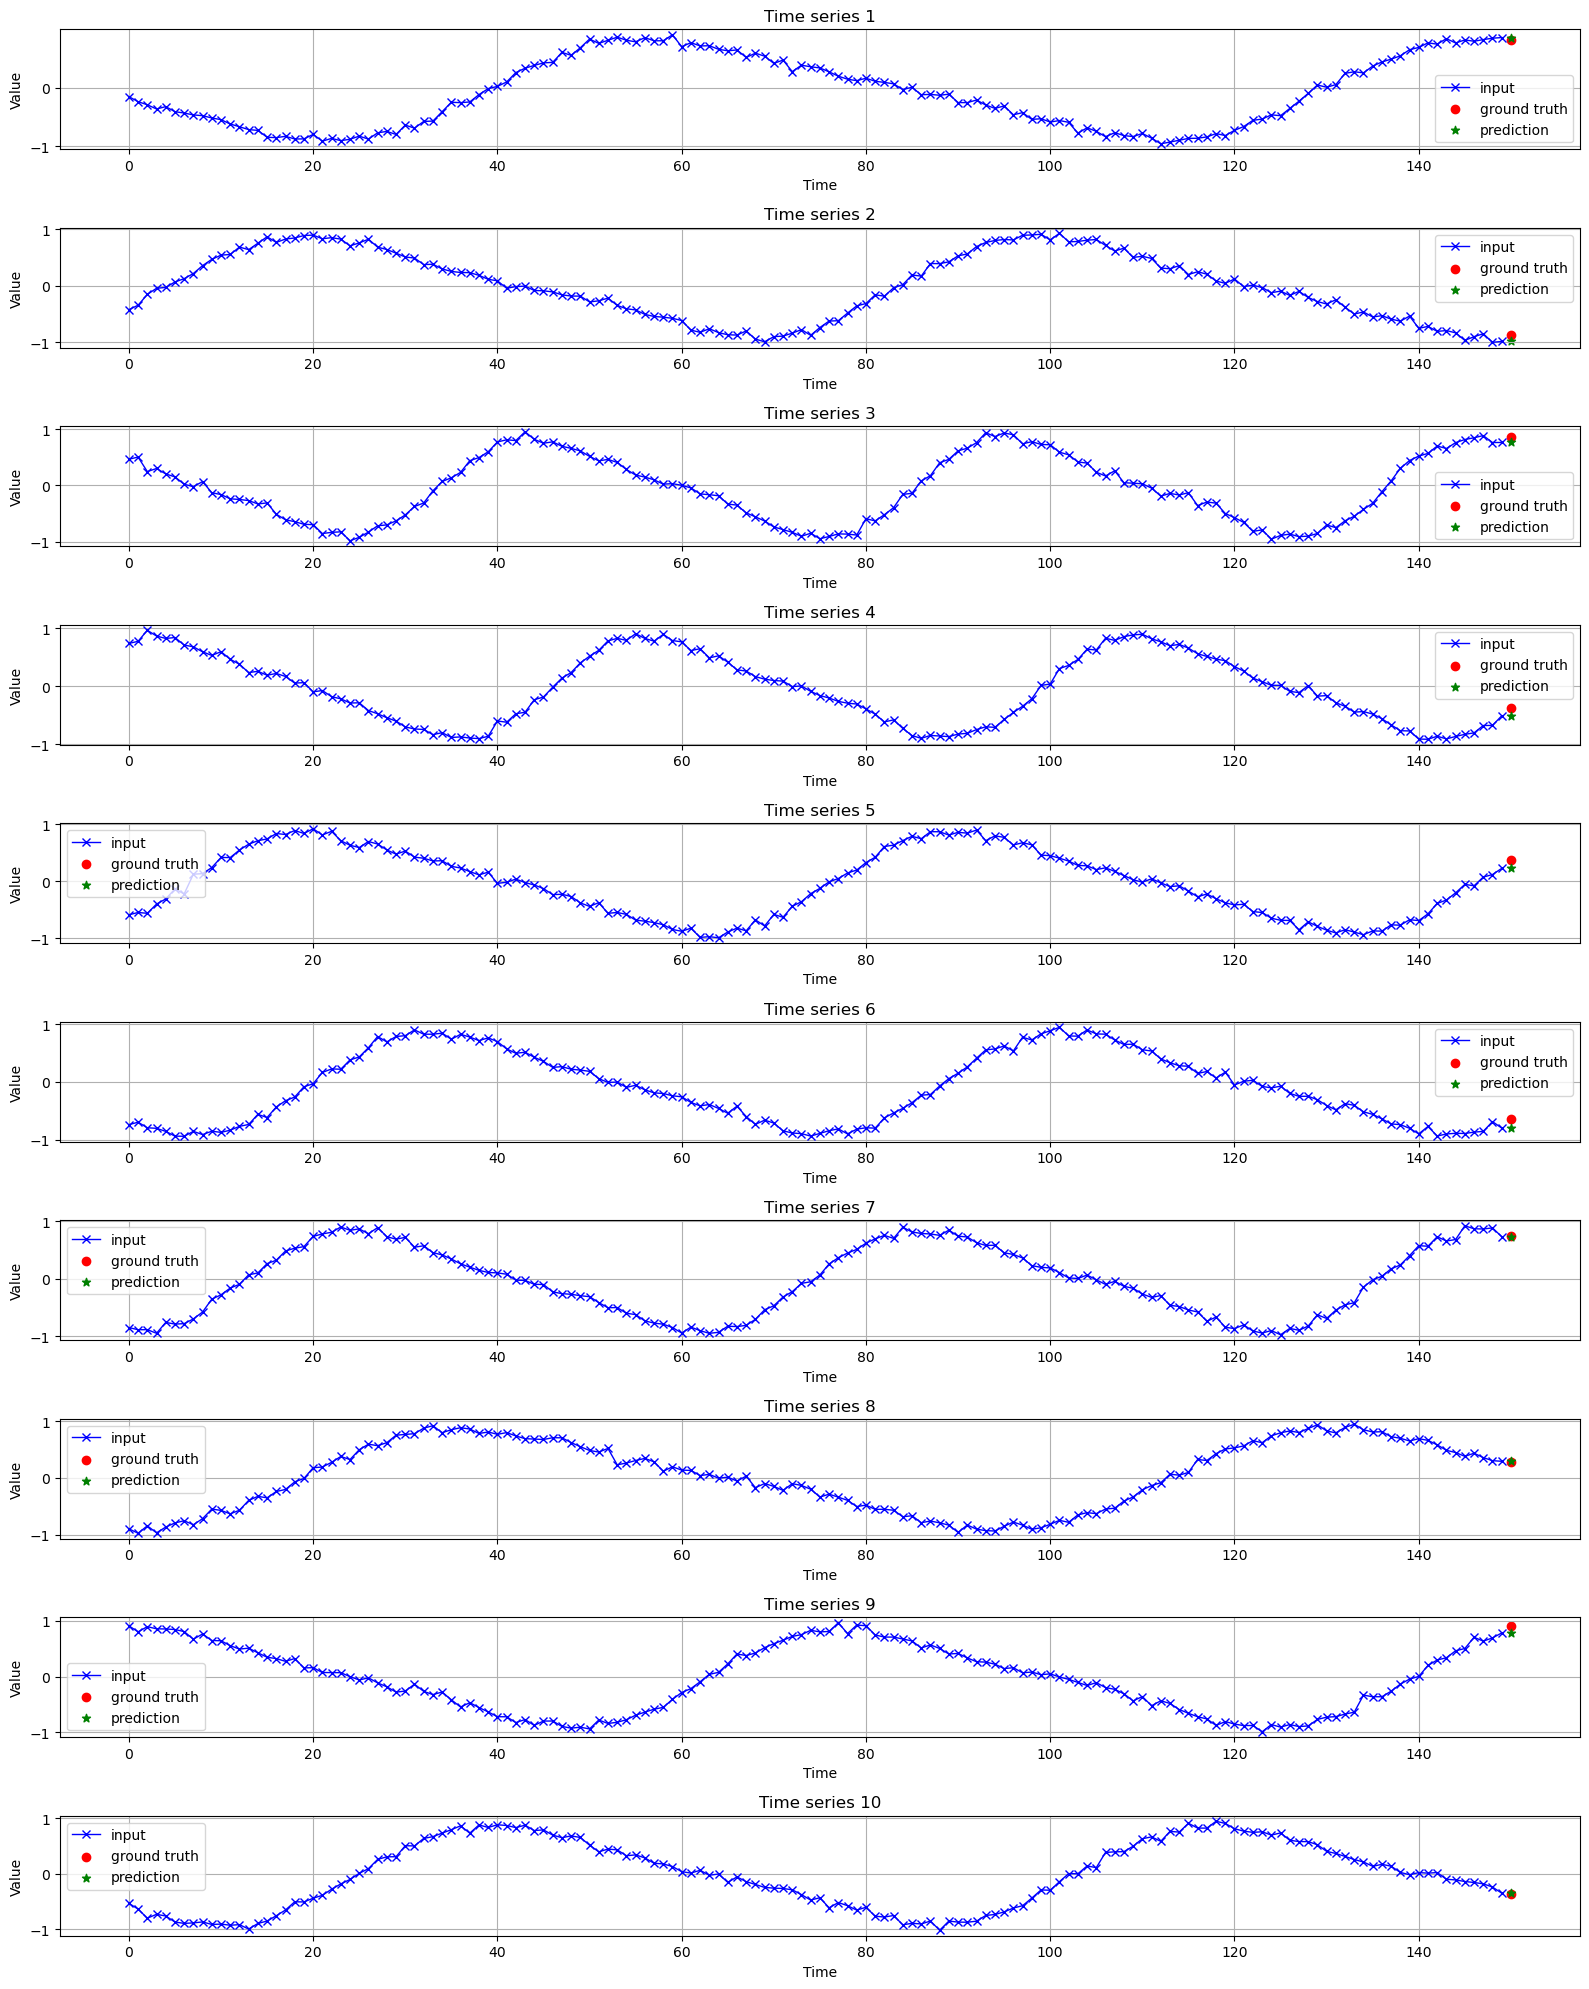

In [10]:
N = 10
fig, axs = plt.subplots(N, 1, figsize=(16, 2 * N))
for i in range(N):
    input = torch.tensor(X_valid[i], device=device)
    target = torch.tensor(y_valid[i], device=device)
    output = y_pred[i]
    target = target.cpu().detach().numpy()
    axs[i].plot(input.cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    axs[i].scatter(n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
    axs[i].scatter(n_steps, output, color='green', marker="*", linewidth=1, label="prediction")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [11]:
# linear model

class LinearLayer(nn.Module):
    def __init__(self, n_steps, n_hidden=50):
        super(LinearLayer, self).__init__()
        self.fc1 = nn.Linear(n_steps, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
def train_linear_model(model,num_epochs=20,batch_size=32,lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    losses = []
    
    for i in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            # loss = F.mse_loss(outputs, targets.view(-1, 1))
            loss = torch.sqrt(torch.sum((outputs - targets.view(-1, 1)) ** 2))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        if (i+1) % 10 == 0: 
            print(f"epoch {i+1}/{num_epochs}, training loss = {epoch_loss:4e}", end="\r")

    return losses

In [13]:
ll = LinearLayer(n_steps).to(device)

losses = train_linear_model(ll, num_epochs=200, batch_size=32, lr=1e-3)

y_pred = ll(torch.tensor(X_valid).to(device))
y_pred = y_pred.cpu().detach().numpy()
print(f"\n{np.mean(np.sqrt((y_valid - y_pred) ** 2)):.4f} RMSE")

epoch 200/200, training loss = 2.940184e-01
0.6788 RMSE


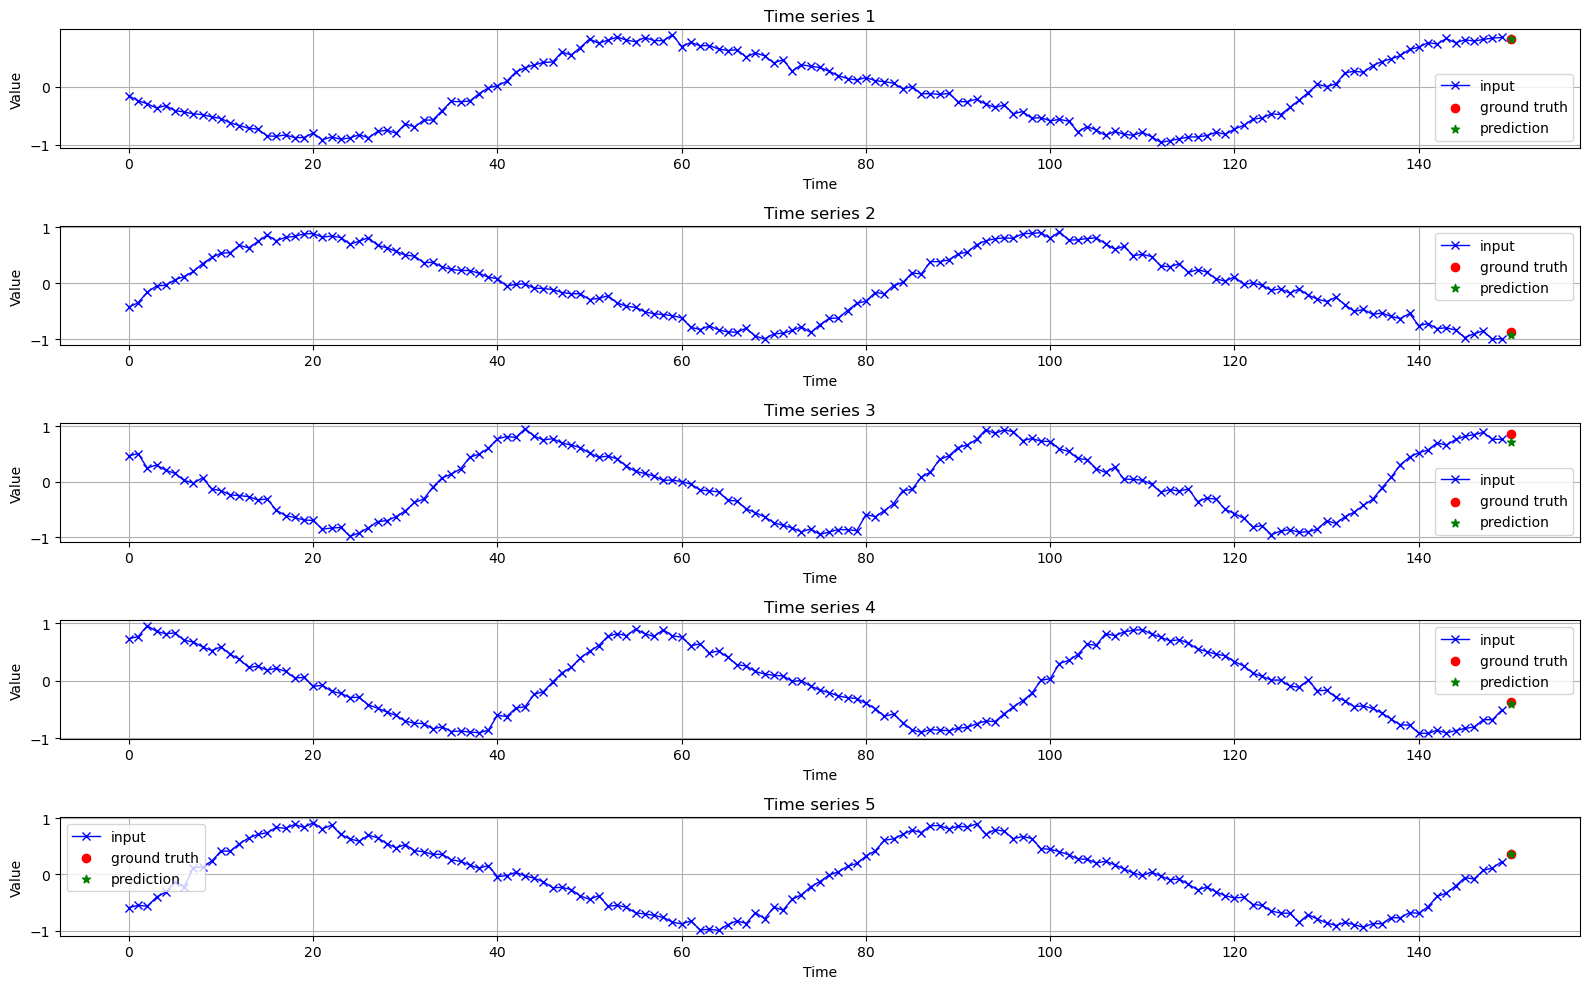

In [14]:
N = 5
fig, axs = plt.subplots(N, 1, figsize=(16, 2 * N))
for i in range(N):
    input = torch.tensor(X_valid[i], device=device)
    target = torch.tensor(y_valid[i], device=device)
    output = ll(input)
    output = output.cpu().detach().numpy()
    target = target.cpu().detach().numpy()
    axs[i].plot(input.cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    axs[i].scatter(n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
    axs[i].scatter(n_steps, output, color='green', marker="*", linewidth=1, label="prediction")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

Basic Torch RNN

In [15]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModel, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        # OUTPUT: x : (batch, output_dimension)
        return x

In [16]:
rnn = RNNModel(
    input_dim=4,
    output_dim=2,
    hidden_dim=64,
    num_layers=1,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModel(
  (rnn): RNN(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)


In [17]:
def train_step(model, optimizer, criterion, train_loader=train_loader):
    ### training step
    model.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, 1)
        # print(f"target has shape {target.shape}")
        output = model(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    return epoch_loss   

In [18]:
def test_step(model, criterion, valid_loader=valid_loader):
    ### testing step
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in valid_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, 1)
            output = model(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(valid_loader)
    return epoch_loss

In [19]:
def train_rnn_model(model, num_epochs=20, batch_size=32):
    print(f"Start training RNN model for {num_epochs} epochs")
    for i in range(num_epochs):
        # loop on training data
        train_step_loss = train_step(model, optimizer, criterion)
        train_losses.append(train_step_loss)
        # test step
        test_step_loss = test_step(model, criterion)
        valid_losses.append(test_step_loss)
        print(f"epoch {i+1}/{num_epochs}, training loss = {train_step_loss:.4e}, validation loss = {test_step_loss:.4e}")
    print("\nTraining finished")
    return train_losses, valid_losses

RNNModel(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Start training RNN model for 50 epochs
epoch 1/50, training loss = 3.2837e-01, validation loss = 3.0096e-01
epoch 2/50, training loss = 2.8217e-01, validation loss = 2.5866e-01
epoch 3/50, training loss = 2.4010e-01, validation loss = 2.1154e-01
epoch 4/50, training loss = 1.8698e-01, validation loss = 1.4941e-01
epoch 5/50, training loss = 1.2688e-01, validation loss = 1.0055e-01
epoch 6/50, training loss = 8.9336e-02, validation loss = 7.5641e-02
epoch 7/50, training loss = 6.7127e-02, validation loss = 5.6996e-02
epoch 8/50, training loss = 5.1293e-02, validation loss = 4.4662e-02
epoch 9/50, training loss = 3.9359e-02, validation loss = 3.3707e-02
epoch 10/50, training loss = 2.8753e-02, validation loss = 2.5610e-02
epoch 11/50, training loss = 2.1265e-02, validation loss = 1.9147e-02
epoch 12/50, training loss = 1.5731e-02, validation loss = 1.7554e-02
epoch 13/50, training 

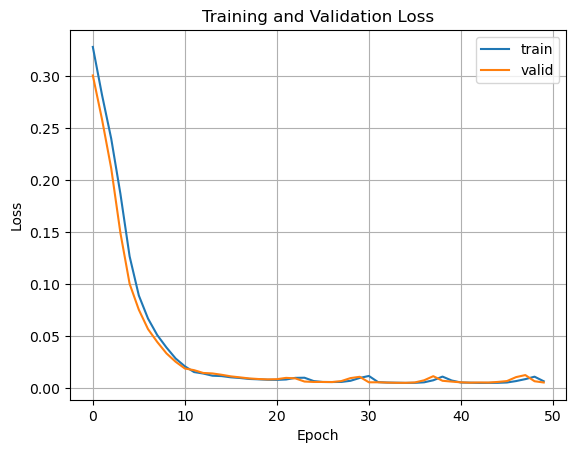

In [20]:
rnn = RNNModel(
    input_dim=1,
    output_dim=1,
    hidden_dim=64,
    num_layers=1,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

lr = 1e-5
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.MSELoss()
train_losses = []
valid_losses = []
num_epochs = 50

train_losses, valid_losses = train_rnn_model(rnn, num_epochs=num_epochs, batch_size=32)

plt.plot(train_losses, label="train")
plt.plot(valid_losses, label="valid")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid()
plt.show()

In [21]:
y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_pred = y_pred.cpu().detach().numpy()

print(f"\n{np.mean(np.sqrt((y_valid - y_pred) ** 2)):.4f} RMSE")


0.6842 RMSE


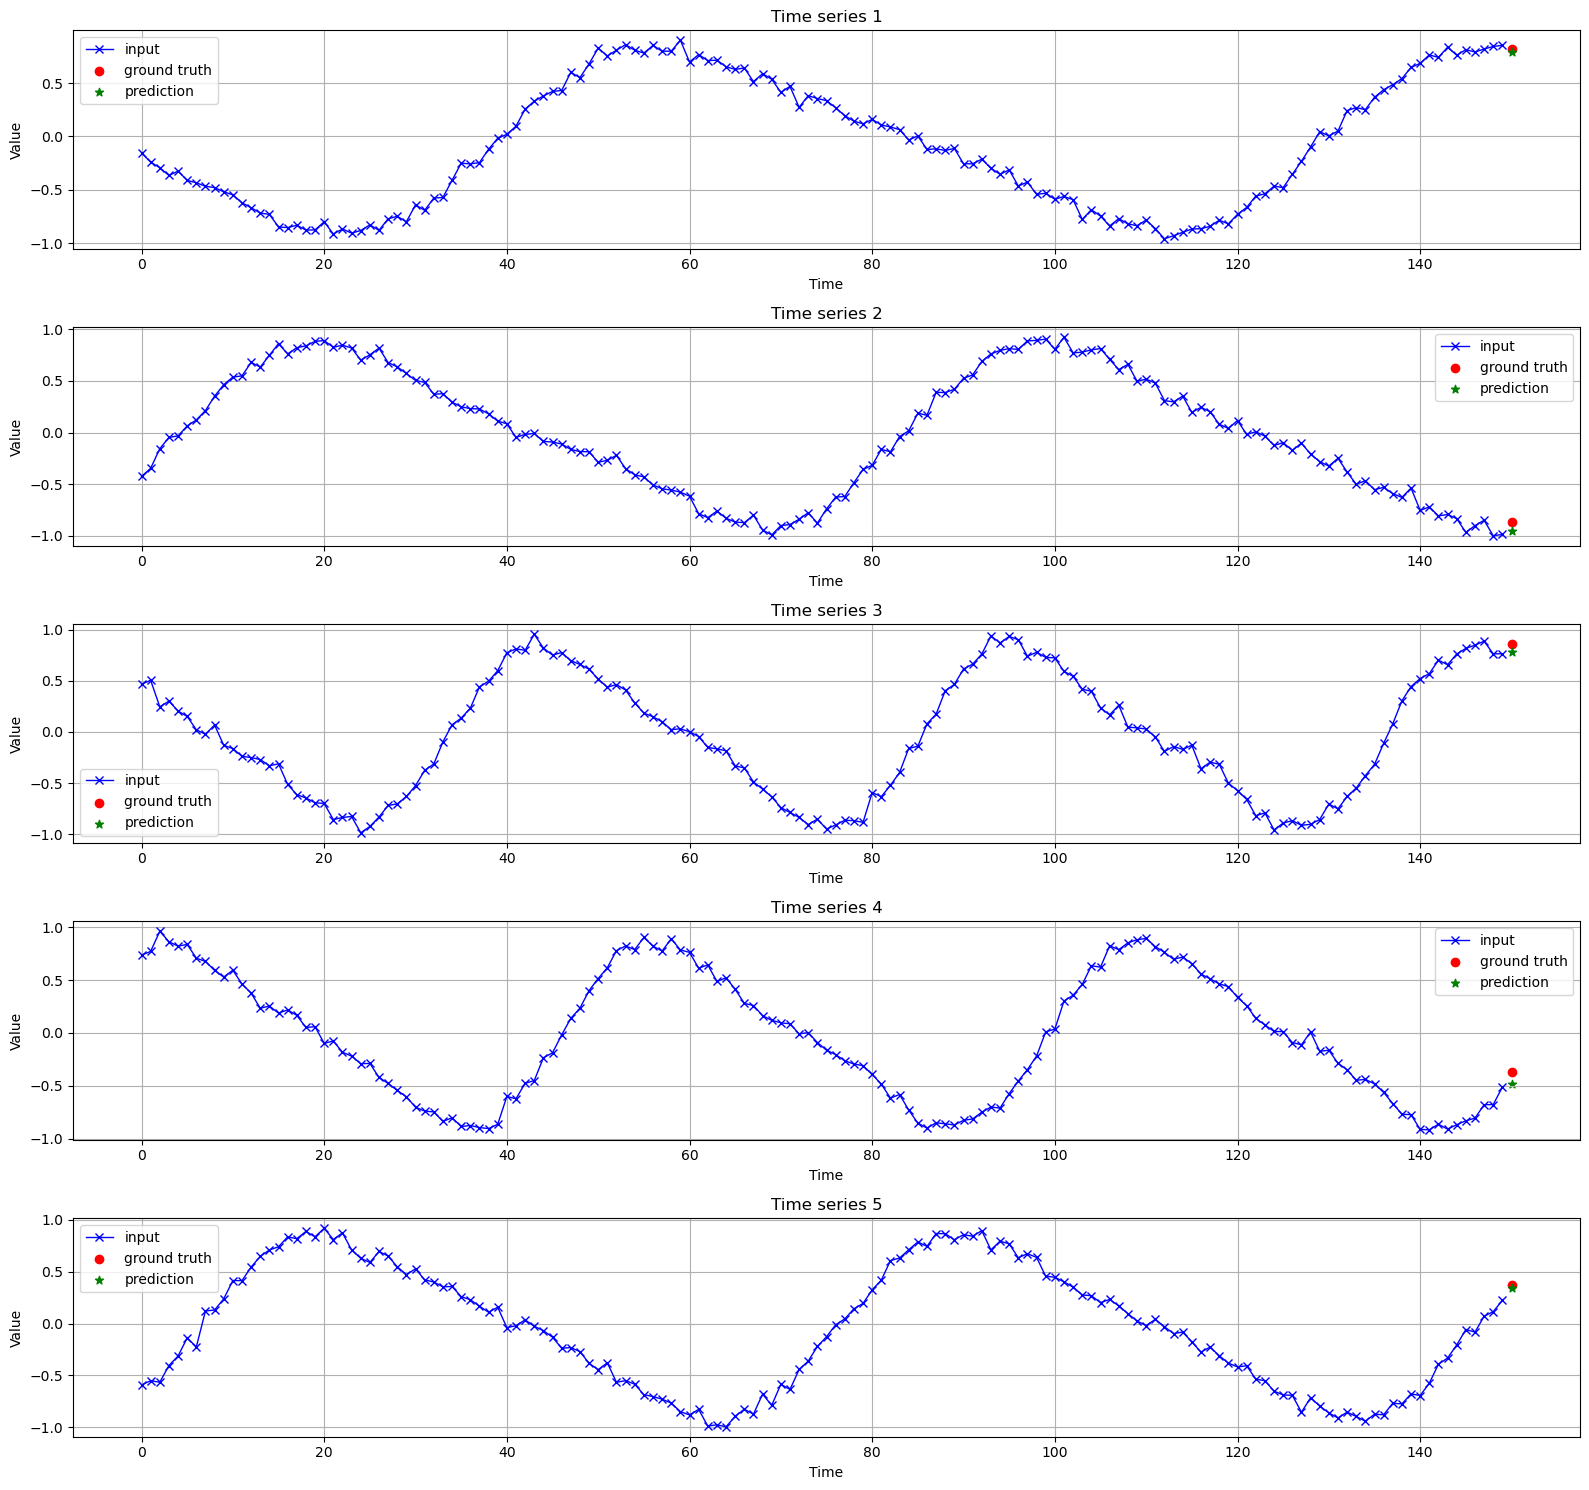

In [22]:
N = 5
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    input = torch.tensor(X_valid[i], device=device).unsqueeze(1).unsqueeze(0)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_valid[i], device=device).view(-1,1)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    axs[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    axs[i].scatter(n_steps, target, color='red', marker="o", linewidth=1, label="ground truth")
    axs[i].scatter(n_steps, output, color='green', marker="*", linewidth=1, label="prediction")
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].legend()
    axs[i].grid(True)
plt.tight_layout()
plt.show()

### Forecast N steps ahead

In [23]:
n_steps = 150
N_AHEAD = 20
n_series = 10000
cutoff = int(n_series * 0.8)

series = generate_time_series(n_series, n_steps + N_AHEAD)

X_train, y_train = series[:cutoff, :n_steps], series[:cutoff, -N_AHEAD:]
X_test, y_test = series[cutoff:, :n_steps], series[cutoff:, -N_AHEAD:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")    
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

X_train shape: (8000, 150)
y_train shape: (8000, 20)
X_test shape: (2000, 150)
y_test shape: (2000, 20)


In [24]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=N_AHEAD, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [29]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=N_AHEAD,
    hidden_dim=128,
    num_layers=4,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=20, bias=True)
)


In [30]:
# Test dimensions

x = torch.randn(32, 50, 1).to(device)
y = rnn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {y.shape}")

input shape: torch.Size([32, 50, 1])
output shape: torch.Size([32, 20, 1])


In [31]:
lr = 1e-5
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.MSELoss()
num_epochs = 20

In [32]:
train_losses = []
valid_losses = []

print(f"Start training RNN model for {num_epochs} epochs")

for i in range(num_epochs):
    # loop on training data
    rnn.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, N_AHEAD, 1)
        # print(f"target has shape {target.shape}")
        output = rnn(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader) 
    train_losses.append(epoch_loss)
    
    # test step
    rnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, N_AHEAD, 1)
            output = rnn(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(test_loader)
    valid_losses.append(epoch_loss)
    
    # report out
    print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

Start training RNN model for 20 epochs
epoch    1/20, training loss = 3.0545e-01, validation loss = 2.6348e-01
epoch    2/20, training loss = 1.7033e-01, validation loss = 1.1447e-01
epoch    3/20, training loss = 1.3719e-01, validation loss = 2.1270e-01
epoch    4/20, training loss = 1.6741e-01, validation loss = 2.0061e-01
epoch    5/20, training loss = 1.4738e-01, validation loss = 1.5505e-01
epoch    6/20, training loss = 1.1450e-01, validation loss = 1.2657e-01
epoch    7/20, training loss = 8.8858e-02, validation loss = 1.0338e-01
epoch    8/20, training loss = 8.6358e-02, validation loss = 1.1850e-01
epoch    9/20, training loss = 8.7002e-02, validation loss = 8.4639e-02
epoch   10/20, training loss = 7.7856e-02, validation loss = 1.0225e-01
epoch   11/20, training loss = 9.0099e-02, validation loss = 1.0035e-01
epoch   12/20, training loss = 7.8833e-02, validation loss = 9.6766e-02
epoch   13/20, training loss = 8.1183e-02, validation loss = 1.3891e-01
epoch   14/20, training l

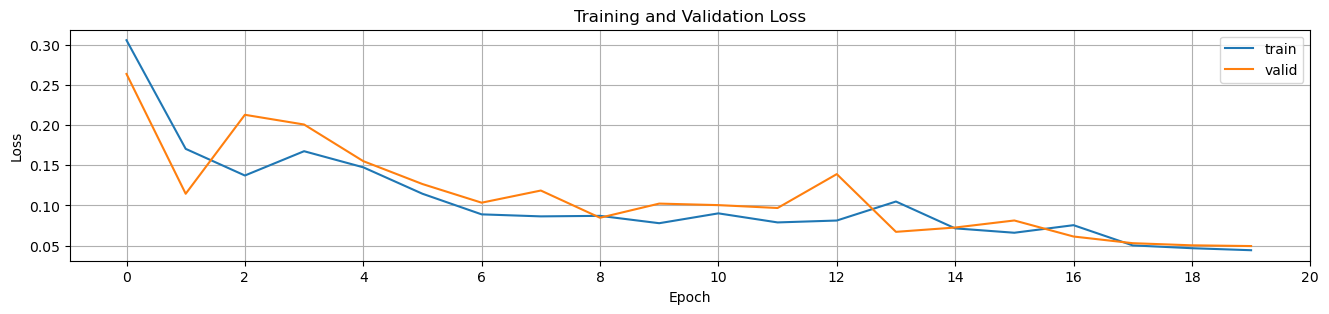

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, num_epochs+1, 2))
ax.set_xticklabels(np.arange(0, num_epochs+1, 2))
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.grid()
plt.show()

In [34]:
y_pred = rnn(torch.tensor(X_test).to(device).unsqueeze(-1))
y_pred = y_pred.cpu().detach().numpy().squeeze()
# print(y_pred.shape)
# print(y_test.shape)

print(f"\n{np.mean(np.sqrt((y_test - y_pred) ** 2)):.4f} RMSE")


0.1733 RMSE


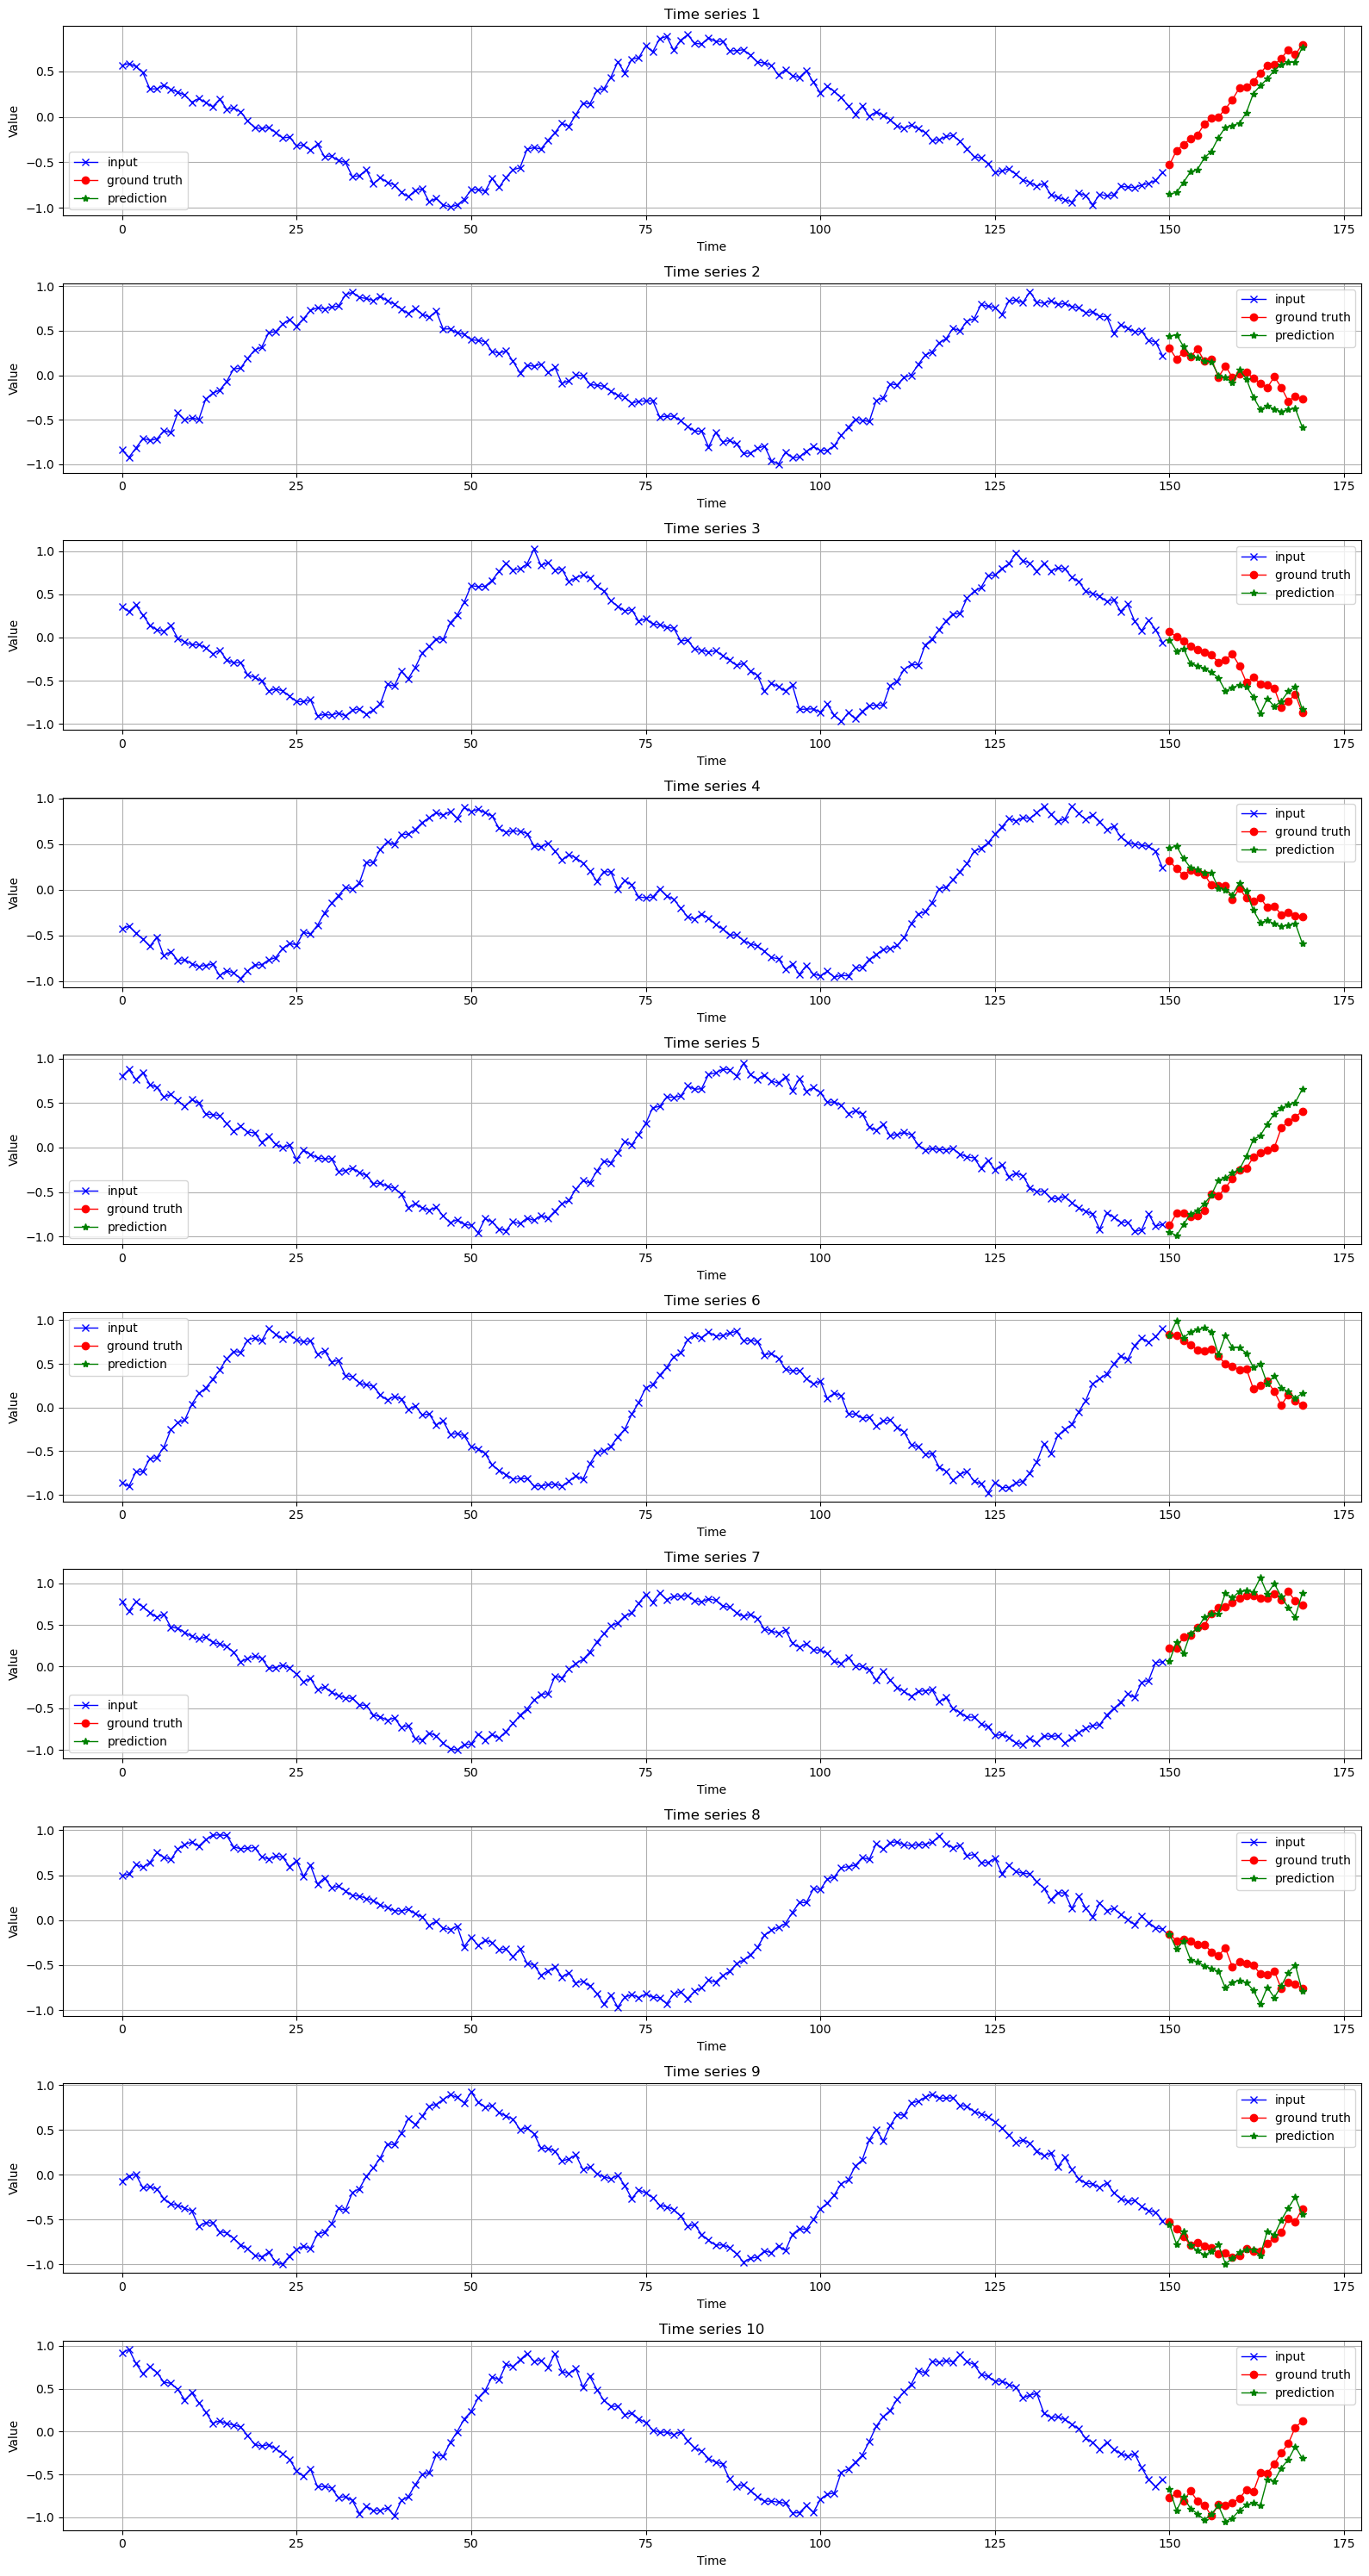

In [35]:
N = 10
fig, ax  = plt.subplots(N, 1, figsize=(16, 3 * N))
x_shift = X_test.shape[-1]

for i in range(N):
    input = torch.tensor(X_test[i], device=device).unsqueeze(0).unsqueeze(-1)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_test[i], device=device).view(-1, N_AHEAD, 1)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    
    ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker="x", linewidth=1, label="input")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
    ax[i].set_title(f"Time series {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Value")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

### Bidirectionnal RNN

https://www.geeksforgeeks.org/bidirectional-recurrent-neural-network/

https://www.kaggle.com/code/amansherjadakhan/introduction-to-bidirectional-rnn